In [1]:
from os.path import join, dirname
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import pingouin as pg

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
list_run = ['r%02d'%(rr+1) for rr in range(3)]

In [5]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [6]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [8]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [9]:
dz = pd.concat([dx, dy])
del dx, dy
dz

,group
GA01,no_stim
GA35,no_stim
GA26,no_stim
GA02,no_stim
GA18,no_stim
...,...
GP62,DLPFC_cTBS
GP63,M1_cTBS
GP65,M1_cTBS
GP66,DLPFC_cTBS


---

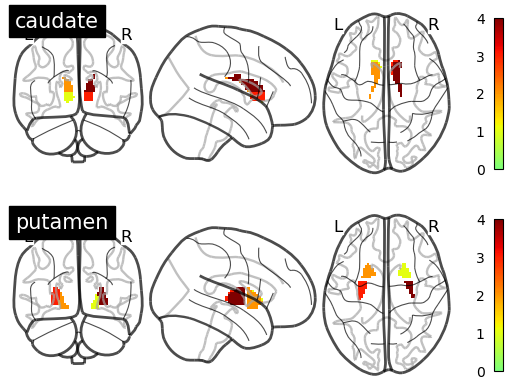

In [10]:
fig, axs = plt.subplots(nrows=2)

imgs = {}
for ii, roi in enumerate(['caudate','putamen']):
    ax = axs[ii]
    imgs[roi] = image.load_img(
        join(dir_mask,'mask.TTatlas.%s.resampled.nii'%roi),
    )
    plotting.plot_glass_brain(
        imgs[roi],
        title=roi,
        cmap=cm.jet, colorbar=True,
        axes=ax
    )

putamen: ra=1, la=2, lp=3, rp=4 \
caudate: la=1, lp=2, ra=3, rp=4

In [11]:
dict_roi = {}
## Putamen
dict_roi['raPU'] = 1
dict_roi['laPU'] = 2
dict_roi['lpPU'] = 3
dict_roi['rpPU'] = 4
## Caudate
dict_roi['laCA'] = 1
dict_roi['lpCA'] = 2
dict_roi['raCA'] = 3
dict_roi['rpCA'] = 4

---

1. 8 ROIs

In [12]:
img_mask = image.math_img(
    img1=imgs['putamen'], img2=imgs['caudate'],
    formula='img1 + (img2+4)*(img2>0)'
)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



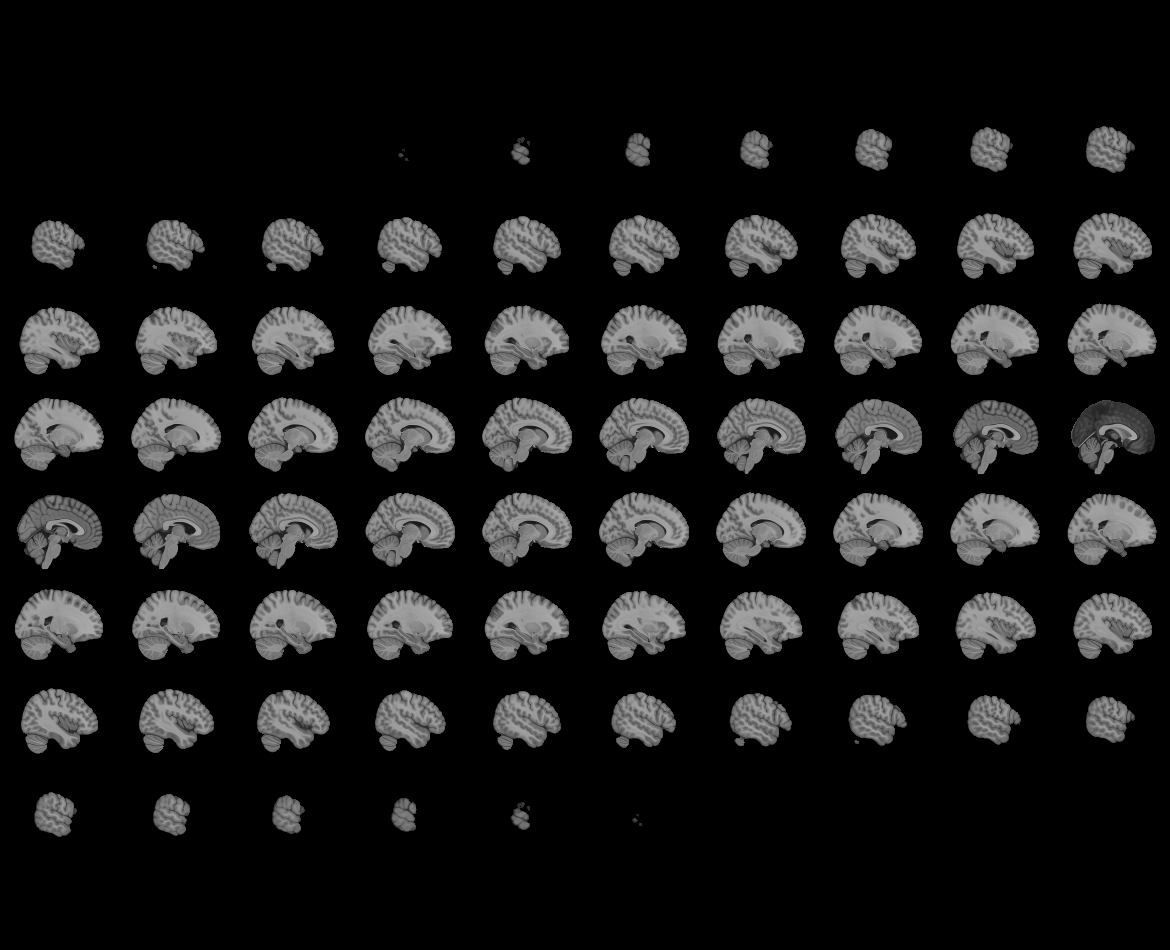
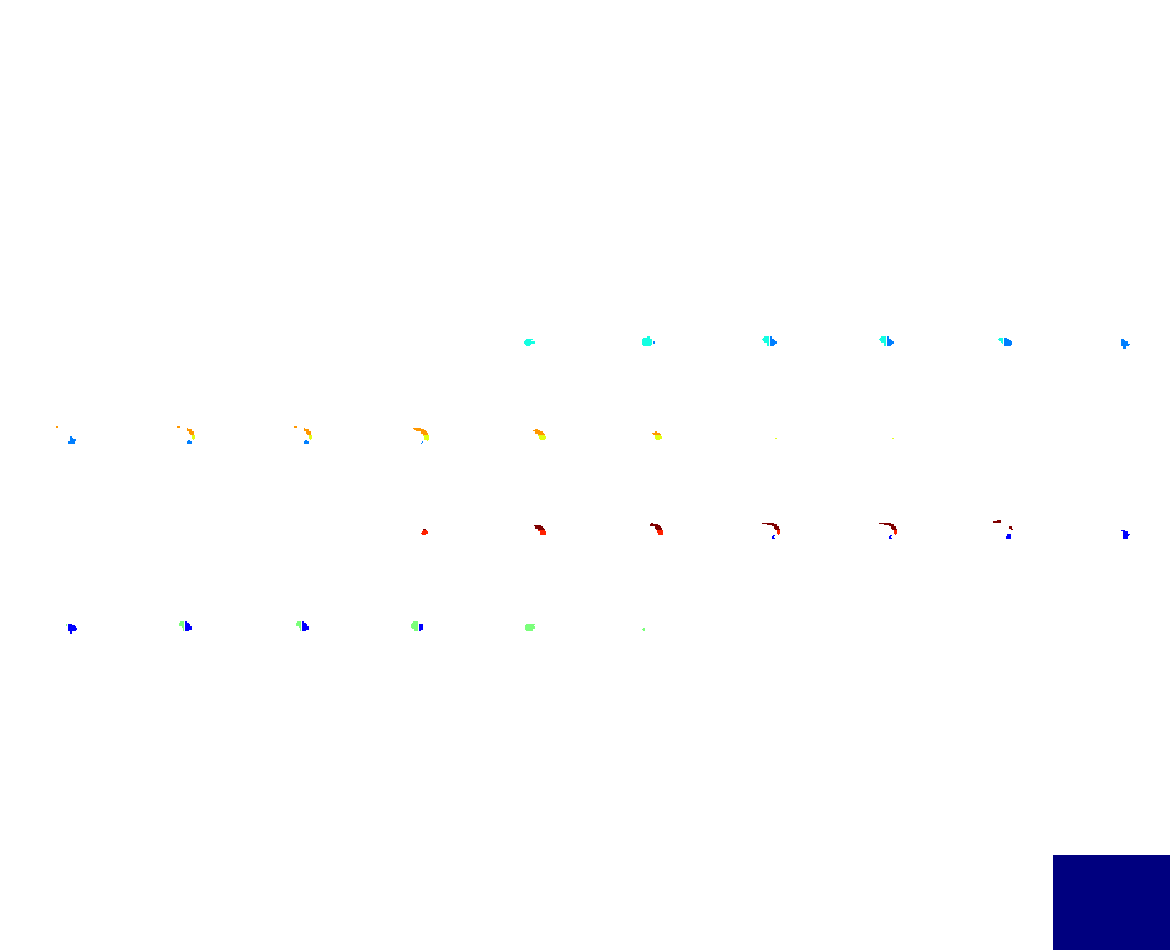

In [13]:
plotting.view_img(
    img_mask,
    cmap=cm.jet.resampled(9), colorbar=True, symmetric_cmap=False,
    resampling_interpolation='nearest'
)

In [14]:
list_label=[
    'raPU', 'laPU', 'lpPU', 'rpPU',
    'laCA', 'lpCA', 'raCA', 'rpCA'
]

---

2. (Left) Anterior vs. Posterior

In [15]:
# img_mask = image.math_img(
#     img1=imgs['putamen'], img2=imgs['caudate'],
#     formula='(img1==%d)+(img2==%d) + ((img1==%d)+(img2==%d))*2'\
#     %(dict_roi['laPU'],dict_roi['laCA'],dict_roi['lpPU'],dict_roi['lpCA'])
# )

In [16]:
# plotting.plot_glass_brain(
#     img_mask,
#     cmap=cm.jet.resampled(10), colorbar=True,
# )

In [17]:
# list_label = ['laST', 'lpST']

---

3. (Left) Putamen vs. Caudate

In [18]:
# img_mask = image.math_img(
#     img1=imgs['putamen'], img2=imgs['caudate'],
#     formula='(img1==%d)+(img1==%d) + ((img2==%d)+(img2==%d))*2'\
#     %(dict_roi['laPU'],dict_roi['lpPU'],dict_roi['laCA'],dict_roi['lpCA'])
# )

In [19]:
# plotting.plot_glass_brain(
#     img_mask,
#     cmap=cm.jet.resampled(10), colorbar=True,
# )

In [20]:
# list_label = ['lPU', 'lCA']

---

In [21]:
dict_nvoxels = {}
tmp = img_mask.get_fdata().astype(int)
for ii, l in enumerate(list_label):
    dict_nvoxels[l] = len(tmp[tmp==ii+1])
dict_nvoxels

{'raPU': 135,
 'laPU': 133,
 'lpPU': 132,
 'rpPU': 105,
 'laCA': 71,
 'lpCA': 103,
 'raCA': 66,
 'rpCA': 109}

In [22]:
masker = NiftiLabelsMasker(
    labels_img=img_mask, labels=list_label,
    memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
)

---

In [23]:
# p_thresh = 5.e-2
# thresh = stats.norm.isf(0.5*p_thresh)

In [24]:
# run='r01'

In [25]:
# group = 'DLPFC_cTBS'
# fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]
# plotting.view_img(
#     fname_Zscr
#     , threshold=thresh
# )

---

In [26]:
prop = 'Rew#1_Coef'

In [27]:
df = pd.DataFrame()

for run in list_run:
    print(run)
    
    ## GA
    a = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
            , 'GA??/%s.%s.GA??.nii'%(prop,run)
        )))
    ## GP
    p = sorted(glob(join(dir_stat,'GP??/%s.%s.GP??.nii'%(prop,run))))
    list_fname = np.concatenate([a,p])

    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']

#         beta = masking.apply_mask(imgs=fname, mask_img=img)
        betas = masker.fit_transform(fname)[0]
        for ii, roi in enumerate(list_label):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'run':run,
                    'roi':roi,
#                     'lr':roi[0], 'ap':roi[1], 'anat':roi[2:],
                    'beta':betas[ii]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
# df.set_index('subj', inplace=True)
# df.index.name = None

r01


100%|██████████| 75/75 [00:02<00:00, 30.71it/s]


r02


100%|██████████| 75/75 [00:02<00:00, 31.76it/s]


r03


100%|██████████| 75/75 [00:02<00:00, 31.05it/s]


In [28]:
df = df.astype({'beta':float})
df

,subj,group,run,roi,beta
0,GA01,no_stim,r01,raPU,0.518611
1,GA01,no_stim,r01,laPU,0.599993
2,GA01,no_stim,r01,lpPU,0.151185
3,GA01,no_stim,r01,rpPU,0.272298
4,GA01,no_stim,r01,laCA,0.538827
...,...,...,...,...,...
1795,GP67,DLPFC_cTBS,r03,rpPU,0.018424
1796,GP67,DLPFC_cTBS,r03,laCA,0.016947
1797,GP67,DLPFC_cTBS,r03,lpCA,-0.135706
1798,GP67,DLPFC_cTBS,r03,raCA,-0.021755


---

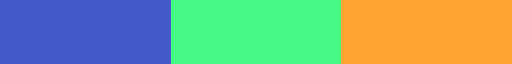

In [29]:
tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp][:3]

colors.ListedColormap(palette)

In [32]:
list_label = [
    'laCA', 'raCA', 'lpCA', 'rpCA',
    'laPU', 'raPU', 'lpPU', 'rpPU'
]

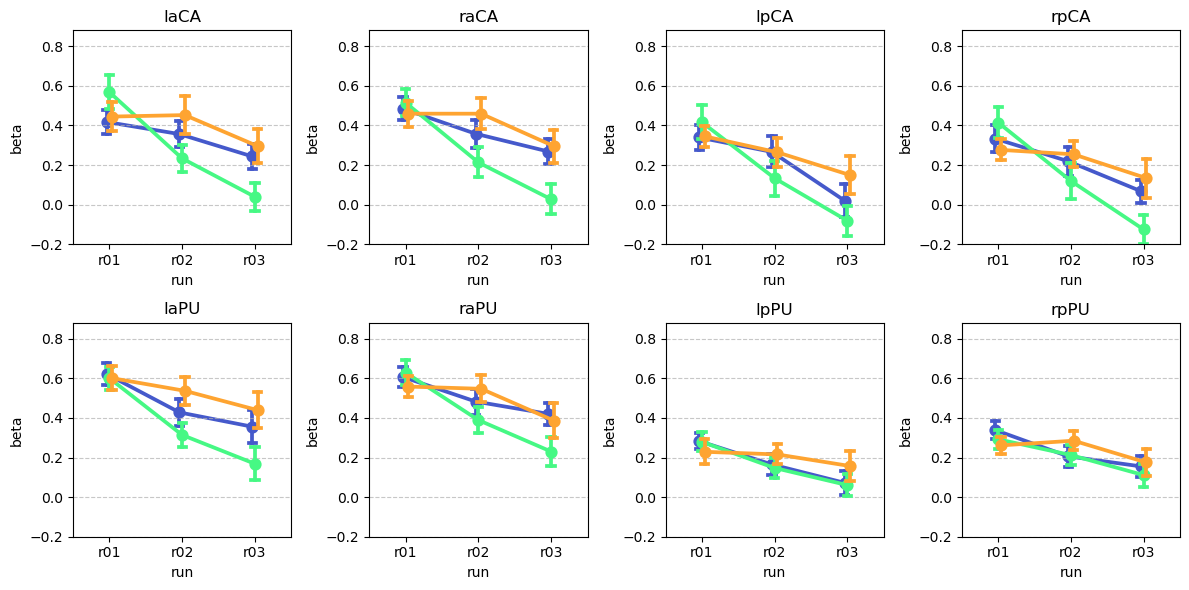

In [33]:
order = ['r01','r02','r03']
hue_order = ['no_stim', 'DLPFC_cTBS','M1_cTBS']

ncols=4
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(list_label):
    ax = axs[ii]
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=order, hue_order=hue_order, palette=palette,
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    ax.set_title(roi)
    ax.set_ylim(-0.2,0.88)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().remove()
    
fig.tight_layout()

---

In [29]:
between = 'group'
within = 'run'

### Fig.3b

In [31]:
plt.rcParams['font.size'] = 12

laCA
lpPU


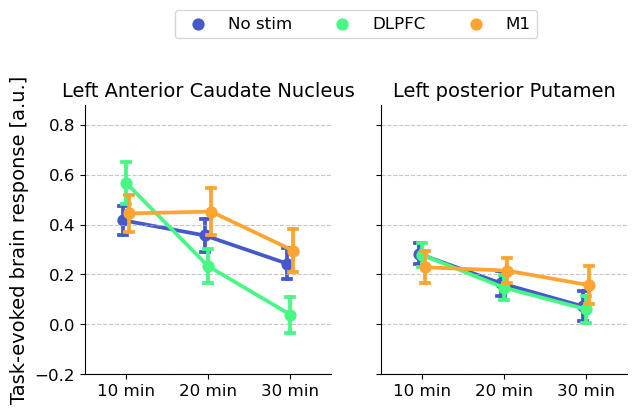

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5))

for ii, roi in enumerate(['laCA','lpPU']):
    ax = axs[ii]
    print(roi)
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=order, hue_order=hue_order, palette=palette,
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    g.grid(axis='y', linestyle='--', alpha=0.7)
    g.set_ylim(-0.2,0.88)
    g.legend().remove()
    g.set_xticklabels(['10 min','20 min','30 min'])
    g.set_xlabel(None)
    if ii == 0:
        g.set_title('Left Anterior Caudate Nucleus', fontsize=14)
        g.set_ylabel('Task-evoked brain response [a.u.]', fontsize=14)
    else:
        g.set_title('Left posterior Putamen', fontsize=14)
        g.set_ylabel('')
        g.set_yticklabels('')
        g.spines['left'].set_visible(False)
        
## Setting legend
h, l = g.get_legend_handles_labels()
l_new = []
for text in l:
    a, b = text.split('_')
    if not text=='no_stim':
#         tmp = r'%s$_{%s}$'%(a.upper(),b)
        tmp = r'%s'%a.upper()
    else:
        tmp = 'No stim'
    l_new.append(tmp)
g.legend(
    h, l_new,
    bbox_to_anchor=(-0.1, 1.3), loc='center', ncol=3,
    fontsize=12
)

sns.despine()
# fig.tight_layout()

In [33]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

In [33]:
df.dtypes

subj      object
group     object
run       object
roi       object
beta     float64
dtype: object

#### ANOVA

In [34]:
pg.mixed_anova(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi=='laCA')],
    dv='beta', within=within, between=between,
    subject='subj'
).round(5)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.35008,2,61,0.17504,0.76824,0.46826,0.02457,NaN
1,run,2.19917,2,122,1.09958,19.68891,0.00000,0.24401,0.95369
2,Interaction,0.96545,4,122,0.24136,4.32180,0.00264,0.12411,NaN


In [35]:
pg.mixed_anova(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi=='lpPU')],
    dv='beta', within=within, between=between,
    subject='subj'
).round(5)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,group,0.04018,2,61,0.02009,0.15633,0.85562,NaN,0.00510,NaN,NaN,NaN,NaN
1,run,0.99331,2,122,0.49665,13.34444,0.00001,0.00002,0.17949,0.8806,False,0.86441,0.01092
2,Interaction,0.13884,4,122,0.03471,0.93261,0.44748,NaN,0.02967,NaN,NaN,NaN,NaN


#### Post-Hoc test

In [36]:
dg = pd.DataFrame(
    columns=['roi','Contrast',between, within,'A','B','Paired','Parametric','T','dof','alternative','p-unc','BF10','none']
)
dg

,roi,Contrast,group,run,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,none


1. ROI: laCA

In [37]:
roi = 'laCA'

In [38]:
tmp = pg.pairwise_tests(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=True
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.run!='-')]
tmp['roi'] = roi
dg = dg.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_1818265/1447121500.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dg = dg.append(tmp, ignore_index=True)


In [39]:
tmp = pg.pairwise_tests(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=False
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.group!='-')]
tmp['roi'] = roi
dg = dg.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_1818265/4083762966.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dg = dg.append(tmp, ignore_index=True)
/tmp/ipykernel_1818265/4083762966.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dg = dg.append(tmp, ignore_index=True)


2. ROI: lpPU

In [40]:
roi = 'lpPU'

In [41]:
tmp = pg.pairwise_tests(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=True
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.run!='-')]
tmp['roi'] = roi
dg = dg.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_1818265/1447121500.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dg = dg.append(tmp, ignore_index=True)
/tmp/ipykernel_1818265/1447121500.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dg = dg.append(tmp, ignore_index=True)


In [42]:
tmp = pg.pairwise_tests(
    data=df[(df.group!='DLPFC_20Hz')&(df.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=False
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.group!='-')]
tmp['roi'] = roi
dg = dg.append(tmp, ignore_index=True)
dg = dg.replace(np.nan,'-')

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_1818265/497640183.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dg = dg.append(tmp, ignore_index=True)
/tmp/ipykernel_1818265/497640183.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dg = dg.append(tmp, ignore_index=True)


In [43]:
dg

,roi,Contrast,group,run,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,none
0,laCA,run * group,-,r03,DLPFC_cTBS,M1_cTBS,False,True,-2.273040,32.000000,two-sided,0.029877,2.242,-0.779646
1,laCA,run * group,-,r03,DLPFC_cTBS,no_stim,False,True,-2.147043,36.994938,two-sided,0.038412,1.826,-0.629056
2,laCA,group * run,DLPFC_cTBS,-,r01,r02,True,True,3.344890,16.000000,two-sided,0.004111,11.3,1.055119
3,laCA,group * run,DLPFC_cTBS,-,r01,r03,True,True,5.281839,16.000000,two-sided,0.000074,368.239,1.631059
4,laCA,group * run,DLPFC_cTBS,-,r02,r03,True,True,3.632577,16.000000,two-sided,0.002240,18.925,0.667316
5,laCA,group * run,no_stim,-,r01,r03,True,True,2.866114,29.000000,two-sided,0.007658,5.649,0.528836
6,lpPU,group * run,DLPFC_cTBS,-,r01,r02,True,True,2.436598,16.000000,two-sided,0.026884,2.402,0.651368
7,lpPU,group * run,DLPFC_cTBS,-,r01,r03,True,True,4.304046,16.000000,two-sided,0.000546,63.906,1.030526
8,lpPU,group * run,no_stim,-,r01,r02,True,True,2.687342,29.000000,two-sided,0.011802,3.916,0.461276
9,lpPU,group * run,no_stim,-,r01,r03,True,True,3.121245,29.000000,two-sided,0.004054,9.749,0.741707


---

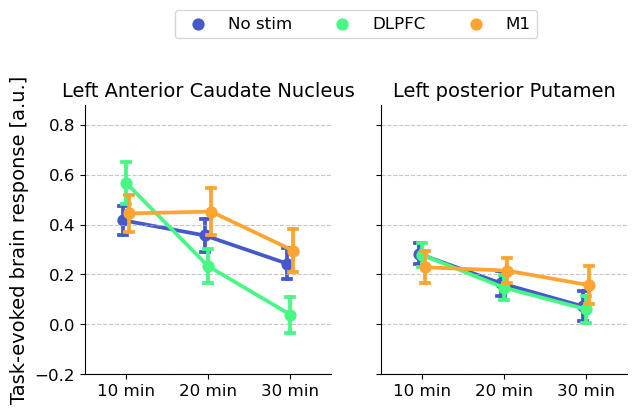

In [33]:
fig

In [34]:
for ii, roi in enumerate(['laCA','lpPU']):
    ax = axs[ii]
    for jj, run in enumerate(['r01','r02','r03']):
        # pg.welch_anova(
        tmp = pg.anova(
            data=df[(df.group!='DLPFC_20Hz')&(df.roi==roi)&(df.run==run)],
            dv='beta', between=between,
            detailed=False
        )
        print(tmp)
        if tmp['p-unc'].values <0.05:
            print(roi, run)

  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  1.216573  0.303329  0.038358
  Source  ddof1  ddof2         F    p-unc       np2
0  group      2     61  1.660913  0.19844  0.051644
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  2.926994  0.061119  0.087564
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.323626  0.724755  0.010499
  Source  ddof1  ddof2         F   p-unc       np2
0  group      2     61  0.370693  0.6918  0.012008
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.557717  0.575406  0.017957


---

dict_keys([('laCA', 1), ('laCA', 2), ('laCA', 3), ('laCA', 4), ('laCA', 5), ('laCA', 6), ('laCA', 7), ('laCA', 8), ('laCA', 9), ('laCA', 11), ('laCA', 12), ('laCA', 13), ('laCA', 14), ('laCA', 15), ('laCA', 16), ('laCA', 17), ('laCA', 18), ('laCA', 19), ('laCA', 21), ('laCA', 22), ('laCA', 23), ('laCA', 24), ('laCA', 25), ('laCA', 26), ('laCA', 27), ('laCA', 28), ('laCA', 29), ('lpPU', 1), ('lpPU', 2), ('lpPU', 3), ('lpPU', 4), ('lpPU', 5), ('lpPU', 6), ('lpPU', 7), ('lpPU', 8), ('lpPU', 9), ('lpPU', 11), ('lpPU', 12), ('lpPU', 13), ('lpPU', 14), ('lpPU', 15), ('lpPU', 16), ('lpPU', 17), ('lpPU', 18), ('lpPU', 19), ('lpPU', 21), ('lpPU', 22), ('lpPU', 23), ('lpPU', 24), ('lpPU', 25), ('lpPU', 26), ('lpPU', 27), ('lpPU', 28), ('lpPU', 29)])


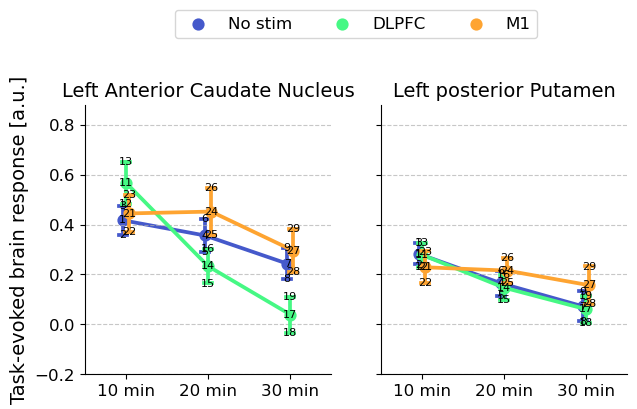

In [44]:
bboxes = {}
for ii, roi in enumerate(['laCA', 'lpPU']):
    ax = axs[ii]
    idx = -1
    for child in ax.get_children():
        if not type(child) is lines.Line2D:
            continue
        idx+=1
        if idx in [0,10,20]:
            continue
        bbox = child.get_bbox()
        ax.text(
            x=(bbox.x0+bbox.x1)*0.5, y=(bbox.y0+bbox.y1)*0.5,
            s=idx, fontsize=8,
            va='center', ha='center'
        )
        bboxes[(roi,idx)] = bbox
print(bboxes.keys())
fig

In [46]:
tmp = np.delete(np.arange(len(hue_order)*len(order)*3 + 3), [0,10,20])
indices = {}
cnt = 0
for h in hue_order:
    for l in ['mid','bottom','top']:
        for o in order:
            indices[(h,l,o)] = tmp[cnt]
            cnt+=1
indices

{('no_stim', 'mid', 'r01'): 1,
 ('no_stim', 'mid', 'r02'): 2,
 ('no_stim', 'mid', 'r03'): 3,
 ('no_stim', 'bottom', 'r01'): 4,
 ('no_stim', 'bottom', 'r02'): 5,
 ('no_stim', 'bottom', 'r03'): 6,
 ('no_stim', 'top', 'r01'): 7,
 ('no_stim', 'top', 'r02'): 8,
 ('no_stim', 'top', 'r03'): 9,
 ('DLPFC_cTBS', 'mid', 'r01'): 11,
 ('DLPFC_cTBS', 'mid', 'r02'): 12,
 ('DLPFC_cTBS', 'mid', 'r03'): 13,
 ('DLPFC_cTBS', 'bottom', 'r01'): 14,
 ('DLPFC_cTBS', 'bottom', 'r02'): 15,
 ('DLPFC_cTBS', 'bottom', 'r03'): 16,
 ('DLPFC_cTBS', 'top', 'r01'): 17,
 ('DLPFC_cTBS', 'top', 'r02'): 18,
 ('DLPFC_cTBS', 'top', 'r03'): 19,
 ('M1_cTBS', 'mid', 'r01'): 21,
 ('M1_cTBS', 'mid', 'r02'): 22,
 ('M1_cTBS', 'mid', 'r03'): 23,
 ('M1_cTBS', 'bottom', 'r01'): 24,
 ('M1_cTBS', 'bottom', 'r02'): 25,
 ('M1_cTBS', 'bottom', 'r03'): 26,
 ('M1_cTBS', 'top', 'r01'): 27,
 ('M1_cTBS', 'top', 'r02'): 28,
 ('M1_cTBS', 'top', 'r03'): 29}

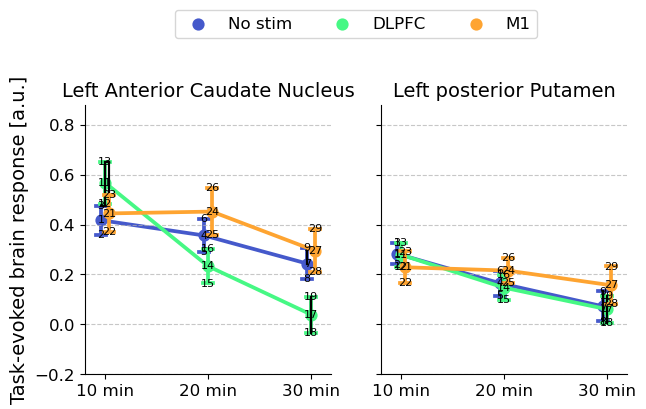

In [56]:
dx = 0
dy = 0

for ii, row in dg.iterrows():
    if row.roi == 'laCA':
        ax = axs[0]
    elif row.roi == 'lpPU':
        ax = axs[1]
    else:
        break

    if row.run == '-':
        ## within (paired)
        keyA = (row.group, 'top', row.A)
        keyB = (row.group, 'top', row.B)
    elif row.group == '-':
        ## between
        keyA = (row.A, 'mid', row.run)
        keyB = (row.B, 'mid', row.run)
    else:
        break
    
    bboxA = bboxes[(row.roi, indices[keyA])]
    bboxB = bboxes[(row.roi, indices[keyB])]
    xA = (bboxA.x0+bboxA.x1)*0.5
    xB = (bboxB.x0+bboxB.x1)*0.5
    yA = (bboxA.y0+bboxA.y1)*0.5
    yB = (bboxB.y0+bboxB.y1)*0.5

    if row.run == '-':
        y = max(yA,yB)
        ax.plot([xA,xA],[yA,y], color='k', linestyle='-')
        ax.plot([xB,xB],[yB,y], color='k', linestyle='-')
        ax.plot([xA,xB],[y,y], color='k', linestyle='-')
    elif row.group == '-':
        x = max(xA,xB)
        ax.plot([xA,x],[yA,yA], color='k', linestyle='-')
        ax.plot([xB,x],[yB,yB], color='k', linestyle='-')
        ax.plot([x,x],[yA,yB], color='k', linestyle='-')
fig

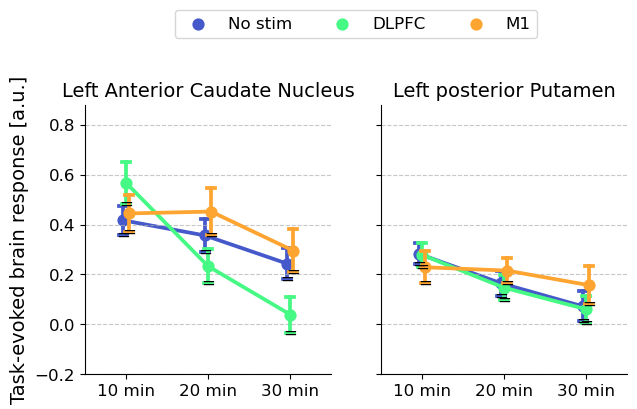

In [81]:
## xy0_xy
for key, xy in xy0_xy.items():
    (a, g, r) = key

    if a == 'ax0':
        ax = axs[0]
    elif a == 'ax1':
        ax = axs[1]
    
    ax.text(
        x = xy[0], y = xy[1],
        s = '=', fontsize = 12,
        va = 'center', ha = 'center'
    )
fig

---

In [32]:
# for xx, group in enumerate(list_group):
#     dx = 0.04*(-1+xx)
#     for ii, r1 in enumerate(list_run):
#         x1 = ii + dx
#         a = df[(df.roi==roi)&(df.group==group)&(df.run==r1)].beta
#         y1 = a.mean()+a.sem() + dy
#         for jj, r2 in enumerate(list_run[ii+1:]):
#             x2 = jj+ii+1 + dx
#             b = df[(df.roi==roi)&(df.group==group)&(df.run==r2)].beta
#             y2 = b.mean()+b.sem() + dy
#             tval, pval = stats.ttest_rel(
#                 a=a.astype(float), b=b.astype(float),
#                 alternative='two-sided'
#             )
#             if pval < 0.05:
#                 print('%s (%s vs. %s): %.5f (%s)'%(group,r1,r2,pval,convert_pvalue_to_asterisks(pval)))
#                 if (r1=='r01')&(r2=='r03'):
#                     if roi=='laCA':
#                         y = 0.81
#                     elif roi=='lpPU':
#                         y = 0.48
#                     dy = -0.025
#                     ro = 0
#                     va = 'bottom'
#                 elif (r1=='r01'):
#                     if roi=='laCA':
#                         y = 0.72
#                     elif roi=='lpPU':
#                         y = 0.39
#                     dy = -0.025
#                     ro = 0
#                     va = 'bottom'
#                 elif (r1=='r02'):
#                     y = -0.1
#                     dy = 0.025
#                     ro = 180
#                     va = 'top'
#                 g.plot([x1,x1],[y+dy,y], color=palette[xx], linestyle='-')
#                 g.plot([x2,x2],[y+dy,y], color=palette[xx], linestyle='-')
#                 g.plot([x1,x2],[y,y], color=palette[xx], linestyle='-')
#                 g.text(
#                     0.5*(x1+x2), y, convert_pvalue_to_asterisks(pval),
#                     ha='center', va=va, rotation=ro, size=11
#                 )
# print('')

# fig

In [27]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

### Fig.4

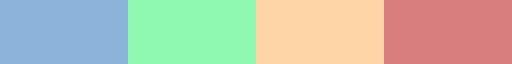

In [37]:
# tmp = cm.terrain(np.linspace(0.2, 0.8, 4))
# palette = [colors.to_rgba(rgb, alpha=1) for rgb in tmp]

# tmp = cm.turbo(np.linspace(0.1,1.0,4))
# palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]
palette = ['#8cb3d9','#8ff8b1','#fed5a6','#d87e7e']

colors.ListedColormap(palette)

r03


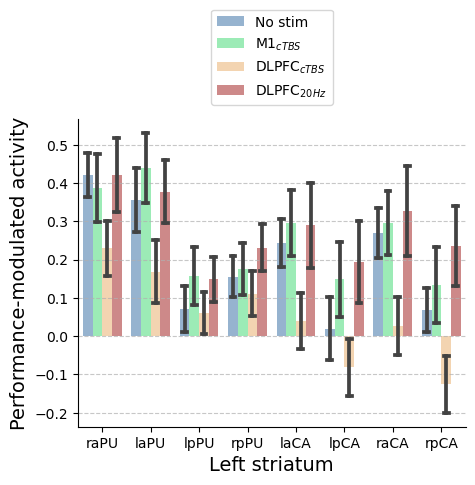

In [38]:
print(run)

fig, ax = plt.subplots(figsize=(5,4))

dg = df[df.run==run]

g = sns.barplot(
    data=dg,
    x='roi', y='beta', hue='group',
    hue_order=('no_stim', 'M1_cTBS', 'DLPFC_cTBS', 'DLPFC_20Hz'),
#     order=['left_anterior','left_posterior'],
    palette=palette,
    errorbar='se', capsize=0.1,
    ax=ax
)
# list_label = g.get_xticklabels()
# g.set_xticklabels(['Anterior','Posterior'], fontsize=13, rotation=0)
g.set_xlabel('Left striatum', fontsize=14)
g.set_ylabel('Performance-modulated activity', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
g.legend(bbox_to_anchor=(0.5, 1.2), loc='center', ncol=1)

list_group = g.get_legend_handles_labels()[-1]
for ii, text in enumerate(list_group):
    if ii==0:
        text_new = 'No stim'
    else:
        a, b = text.split('_')
        text_new = r'%s$_{%s}$'%(a.upper(),b)
    g.legend_.texts[ii].set_text(text_new)

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

In [34]:
list_pair = []
for aa in list_group:
    for bb in list_label:
        list_pair.append((aa,bb))

list_rect = []
list_line = []
for child in g.get_children():
    if type(child) is patches.Rectangle:
        list_rect.append(child)
    elif type(child) is lines.Line2D:
        list_line.append(child)
list_rect = list_rect[:8]
list_line = list_line[:3*8]

dict_rect = {}
for pair, rect in zip(list_pair, list_rect):
    print(pair, rect)
    dict_rect[pair] = pair

dict_line = {}
for ii, pair in enumerate(list_pair):
    for jj, line in enumerate(list_line[ii*3:(ii+1)*3]):
        kk = 'mid' if jj==0 else ('bottom' if jj==1 else ('top' if jj==2 else 'invalid'))
#         print((*(pair), kk), line)
        dict_line[(*(pair), kk)] = line

del list_pair, list_rect, list_line

('no_stim', 'laST') Rectangle(xy=(-0.4, 0), width=0.2, height=0.316564, angle=0)
('no_stim', 'lpST') Rectangle(xy=(0.6, 0), width=0.2, height=0.049152, angle=0)
('M1_cTBS', 'laST') Rectangle(xy=(-0.2, 0), width=0.2, height=0.389095, angle=0)
('M1_cTBS', 'lpST') Rectangle(xy=(0.8, 0), width=0.2, height=0.153408, angle=0)
('DLPFC_cTBS', 'laST') Rectangle(xy=(2.77556e-17, 0), width=0.2, height=0.123386, angle=0)
('DLPFC_cTBS', 'lpST') Rectangle(xy=(1, 0), width=0.2, height=-0.00174429, angle=0)
('DLPFC_20Hz', 'laST') Rectangle(xy=(0.2, 0), width=0.2, height=0.346694, angle=0)
('DLPFC_20Hz', 'lpST') Rectangle(xy=(1.2, 0), width=0.2, height=0.168443, angle=0)


In [42]:
for roi in dg.roi.unique():
    print(roi)
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
#             kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')
            kk = 'two-sided'

            a = dg[(dg.group==g1)&(dg.roi==roi)].beta
            b = dg[(dg.group==g2)&(dg.roi==roi)].beta
            print('%s (n=%d) vs %s (n=%d) (%s):   '%(g1,len(a),g2,len(b),kk), end='\t')

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float),
                alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
    print('')

laST
no_stim (n=30) vs M1_cTBS (n=17) (two-sided):   	0.4384 (ns)
no_stim (n=30) vs DLPFC_cTBS (n=17) (two-sided):   	0.0354 (*)
no_stim (n=30) vs DLPFC_20Hz (n=11) (two-sided):   	0.7240 (ns)
M1_cTBS (n=17) vs DLPFC_cTBS (n=17) (two-sided):   	0.0263 (*)
M1_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.8324 (ns)
DLPFC_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.0701 (ns)

lpST
no_stim (n=30) vs M1_cTBS (n=17) (two-sided):   	0.5649 (ns)
no_stim (n=30) vs DLPFC_cTBS (n=17) (two-sided):   	0.1840 (ns)
no_stim (n=30) vs DLPFC_20Hz (n=11) (two-sided):   	0.4269 (ns)
M1_cTBS (n=17) vs DLPFC_cTBS (n=17) (two-sided):   	0.0761 (ns)
M1_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.9812 (ns)
DLPFC_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.0777 (ns)

{'laST': 2, 'lpST': 0}


laST
no_stim (90) vs M1_cTBS (51) (two-sided):
0.3322 (ns)
no_stim (90) vs DLPFC_cTBS (51) (greater):
0.0552 (ns)
no_stim (90) vs DLPFC_20Hz (33) (greater):
0.0827 (ns)
M1_cTBS (51) vs DLPFC_cTBS (51) (greater):
0.0137 (*)
M1_cTBS (51) vs DLPFC_20Hz (33) (greater):
0.0208 (*)
DLPFC_cTBS (51) vs DLPFC_20Hz (33) (less):
0.5128 (ns)

lpST
no_stim (90) vs M1_cTBS (51) (two-sided):
0.6308 (ns)
no_stim (90) vs DLPFC_cTBS (51) (greater):
0.2329 (ns)
no_stim (90) vs DLPFC_20Hz (33) (greater):
0.4298 (ns)
M1_cTBS (51) vs DLPFC_cTBS (51) (greater):
0.1369 (ns)
M1_cTBS (51) vs DLPFC_20Hz (33) (greater):
0.2866 (ns)
DLPFC_cTBS (51) vs DLPFC_20Hz (33) (less):
0.3351 (ns)



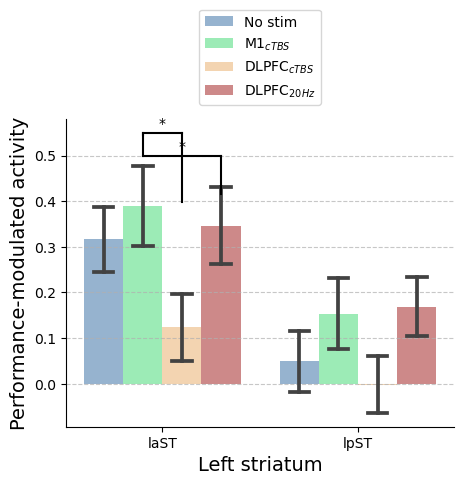

In [38]:
yApart = 0.02

for roi in df.roi.unique():
    print(roi)
    tmp = [0.5+0.05*ii for ii in range(cnt[roi])]
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
            kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')

            a = df[(df.group==g1)&(df.roi==roi)].beta
            b = df[(df.group==g2)&(df.roi==roi)].beta
            print('%s (%d) vs %s (%d) (%s):'%(g1,len(a),g2,len(b),kk))

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float)
                , alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
            
            if pval < 0.05:
                cnt[roi] -= 1
                [x10,y10],[x11,y11] = np.array(dict_rect[(g1,roi)].get_bbox())
                x1 = (x10+x11)*0.5
                [x20,y20],[x21,y21] = np.array(dict_rect[(g2,roi)].get_bbox())
                x2 = (x20+x21)*0.5
                
                yUEdge = tmp[cnt[roi]]
                g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
                g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
                g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
                g.text(
                    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
                    , ha='center', va='center', rotation=0, size=10
                )
    print('')
fig

In [33]:
for ii, group in enumerate(list_group):
    width = dict_rect[(group,'left_anterior')].get_width()
    h1 = dict_rect[(group,'left_anterior')].get_height()
    h2 = dict_rect[(group,'left_posterior')].get_height()
    height = h1 - h2
    x2 = dict_rect[(group,'left_posterior')].get_x()
    xy = (x2, h2)
    color = (*palette[ii][:3], 0.5)
    g.add_patch(patches.Rectangle(
        xy=xy, width=width, height=height
        , facecolor=color, edgecolor=None
#         , hatch='o'
    ))
fig

KeyError: ('no_stim', 'left_anterior')

In [24]:
cnt['diff'] = 0
r1, r2 = 'anterior', 'posterior'
print("%s vs. %s"%(r1, r2))
list_ = g.get_legend_handles_labels()[-1]
for ii, g1 in enumerate(list_):
    for g2 in list_[ii+1:]:
        print('%s vs %s'%(g1,g2))
        kk = 'greater' if 'M1' in g1 else ('less' if 'M1' in g2 else 'two-sided')
        
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

        tval, pval = stats.ttest_ind(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        tval, pval = stats.ranksums(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        if pval < 0.05:
            cnt['diff'] += 1
cnt

anterior vs. posterior
no_stim vs M1_cTBS
0.5302 (ns)
0.3451 (ns)
no_stim vs DLPFC_cTBS
0.0019 (**)
0.0018 (**)
no_stim vs DLPFC_20Hz
0.5731 (ns)
0.3464 (ns)
M1_cTBS vs DLPFC_cTBS
0.0101 (*)
0.0069 (**)
M1_cTBS vs DLPFC_20Hz
0.3535 (ns)
0.2330 (ns)
DLPFC_cTBS vs DLPFC_20Hz
0.1121 (ns)
0.2126 (ns)


{'left_anterior': 0, 'left_posterior': 0, 'diff': 2}

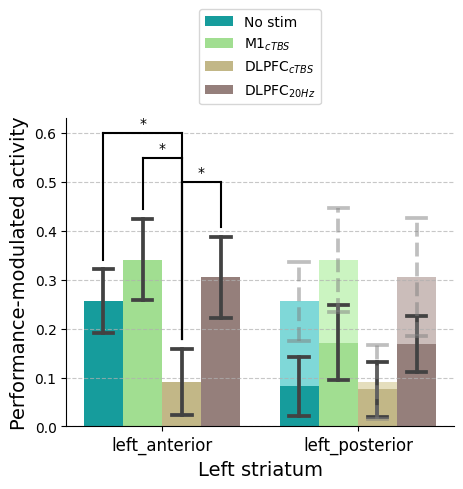

In [25]:
dict_ = {}
for legend in g.get_legend_handles_labels()[-1]:
    a = df[(df.group==legend)&(df.roi=='left_anterior')].beta
    b = df[(df.group==legend)&(df.roi=='left_posterior')].beta
    mean = (a-b).mean()
    std = (a-b).std()
    dy = std*0.5

    ref_bottom = dict_line[(legend, 'left_posterior', 'bottom')].get_bbox()
    x0 = ref_bottom.x0
    x1 = ref_bottom.x1
    xm = (x0+x1)*0.5

    ref_mid = dict_line[(legend, 'left_posterior', 'mid')].get_bbox()
    h = (ref_mid.y0+ref_mid.y1)*0.5 + mean

    width = dict_line[(legend, 'left_posterior', 'mid')].get_linewidth()

    mid = [[xm,xm],[h-dy,h+dy]]
    g.add_line(lines.Line2D(mid[0], mid[1], color='gray', alpha=0.5, linewidth=width, linestyle='--'))
    bottom = [[x0,x1],[h-dy,h-dy]]
    g.add_line(lines.Line2D(bottom[0], bottom[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))
    top = [[x0,x1],[h+dy,h+dy]]
    dict_[legend] = top
    g.add_line(lines.Line2D(top[0], top[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))

fig

In [ ]:
## t test
yApart = 0.02
roi = 'diff'
for ii, g1 in enumerate(list_group)
    for jj, g2 in enumerate(list_group[ii+1]):
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

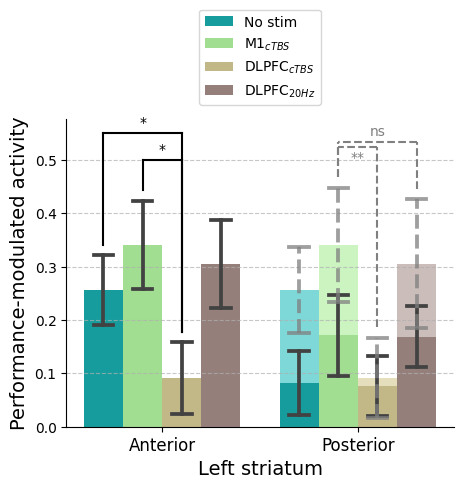

In [42]:
## t test
N = 4
yApart = [-0.02, 0.02]

g2 = 'M1_cTBS'
for ii, g1 in enumerate(['DLPFC_cTBS', 'DLPFC_20Hz']):
    a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
    b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

    c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
    d = df[(df.group==g2)&(df.roi=='left_posterior')].beta
    tval, pval = stats.ranksums(
        (a-b).values.astype(float), (c-d).values.astype(float)
        , alternative='less'
    )

    x1 = (dict_[g1][0][0]+dict_[g1][0][1])*0.5
    x2 = (dict_[g2][0][0]+dict_[g2][0][1])*0.5
    
    yUEdge = tmp[ii]
    g.plot([x1, x1], [dict_[g1][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x2, x2], [dict_[g2][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x1, x2], [yUEdge, yUEdge], color='gray', linestyle='--')
    g.text(
        (x1+x2)*0.5, yUEdge+yApart[ii], convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='gray'
    )

g.set_xticklabels(['Anterior', 'Posterior'], fontsize=12)

fig

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)
/tmp/ipykernel_450850/807858559.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


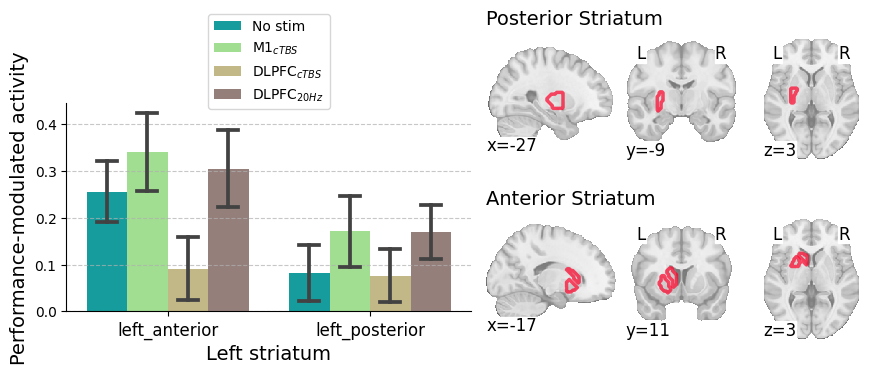

In [35]:
## add rois
w, h = 0.26, 0.3
dy = 0.1
rects = [
    [
        (1, 0+dy ,w, h),
        (1+w, 0+dy ,w, h),
        (1+2*w, 0+dy ,w, h)
    ],
    [
        (1, 0.45+dy ,w, h),
        (1+w, 0.45+dy ,w, h),
        (1+2*w, 0.45+dy ,w, h)
    ]
]
coord = [[-17,11,3], [-27,-9,3]]
for ii, (roi, img) in enumerate(imgs.items()):
    for jj, axis in enumerate(['x','y','z']):
        ax_insert = fig.add_axes(rect=rects[ii][jj])
        plotting.plot_roi(
            img, black_bg=False
            , display_mode=axis
            , cut_coords=[coord[ii][jj]], draw_cross=False
            , view_type='contours', linewidths=2.5
            , cmap='gist_rainbow'
            , axes=ax_insert
        )

for ii, roi in enumerate(['Posterior','Anterior']):
    fig.text(
        x=1, y=0.9 - 0.45*ii
        , s='%s Striatum'%roi
        , fontsize=14
        , horizontalalignment='left'
        , verticalalignment='center'
    )

fig.tight_layout()
fig

In [25]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---